## Expectation Maximization Algorithm Implementation for Brain Tissue Segmentation

This Notebook contains all the necessary code to train, evaluate, and visualize the algorithm. It is divided into the following sections:
1. Imports
2. Classes Definitions (Implementations)
3. Evaluation
4. Visualization

Lab Members:
1. Abdelrahman Usama Gabr Abdou Habib
2. Berta Calm Salvans

### 1. Imports

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from tqdm import tqdm

from loguru import logger
import pandas as pd

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

### 2. Classes Definitions (Implementations)

In [2]:
class NiftiManager:
    def __init__(self) -> None:
        pass

    def load_nifti(self, file_path):
        '''Loads the NIfTI image and access the image data as a Numpy array.'''
        nii_image = nib.load(file_path)
        data_array = nii_image.get_fdata()

        return data_array, nii_image

    def show_nifti(self, file_data, title, slice=25):
        '''Displays a single slice from the nifti volume (change the slice index as needed).'''
        plt.imshow(file_data[:, :, slice], cmap='gray')
        plt.title(title)
        plt.colorbar()
        plt.show()

    def show_label_seg_nifti(self, label, seg, subject_id, slice=25):
        '''Displays both segmentation and ground truth labels as passed to the function.'''
        plt.figure(figsize=(20, 7))
        
        plt.subplot(1, 2, 1)
        plt.imshow(label[:, :, slice], cmap='gray') 
        plt.title(f'Label Image (Subject ID={subject_id})')
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.imshow(seg[:, :, slice], cmap='gray') 
        plt.title(f'Segmentation Image (Subject ID={subject_id})')
        plt.colorbar()
        plt.show()

    def normalize_nifti(self, volume):
        '''Performs Min-Max scaling normalization on nifti volumes.'''
        # Calculate the minimum and maximum values of the volume
        min_val = np.min(volume)
        max_val = np.max(volume)

        # Perform min-max scaling normalization
        normalized_volume = (volume - min_val) / (max_val - min_val)

        return normalized_volume

class Evaluate:
    def __init__(self) -> None:
        pass

    def calc_dice_coefficient(self, mask1, mask2):
        # Ensure the masks have the same shape
        if mask1.shape != mask2.shape:
            raise ValueError("Input masks must have the same shape.")

        # Compute the intersection and union of the masks
        intersection = np.sum(mask1 * mask2)
        union = np.sum(mask1) + np.sum(mask2)

        # Calculate the Dice coefficient
        dice = (2.0 * intersection) / (union + 1e-8)  # Add a small epsilon to avoid division by zero

        return dice

class EM:
    def __init__(self, subject_id, K=3, params_init_type='random', modality='multi'):
        self.subject_id         = subject_id
        self.K                  = K
        self.params_init_type   = params_init_type
        self.modality           = modality

        self.sum_tolerance          = 1e-3
        self.convergence_tolerance  = 200
        self.seed                   = 42

        # Setting a seed
        np.random.seed(self.seed)

        # Nifti Manager class
        self.NM = NiftiManager()

        # Removing the background for the data
        self.tissue_data, self.gt_binary, self.img_shape \
                            = self.perform_skull_stripping()    # (456532, 2) for tissue data
        self.n_samples      = self.tissue_data.shape[0] # 456532 samples
        self.n_features     = self.tissue_data.shape[1] # number of features 2 or 1 (dimension), based on the number of modalities we pass

        # create parameters objects
        self.clusters_means = np.zeros((self.K, self.n_features))                       # (3, 2)
        self.clusters_covar = np.zeros(((self.K, self.n_features, self.n_features)))    # (3, 2, 2)
        self.alpha_k        = np.ones(self.K)                                           # prior probabilities, (3,)

        self.posteriors     = np.zeros((self.n_samples, self.K), dtype=np.float64)      # (456532, 3)
        self.pred_labels    = np.zeros((self.n_samples,))                               # (456532,)
        self.loglikelihood  = [-np.inf]

        if self.modality not in ['single', 'multi']:
            raise ValueError('Wronge modality type passed. Only supports "single" or "multi" options.')

        # assign the parameters their initial values
        self.initialize_parameters(data=self.tissue_data)
    
    def perform_skull_stripping(self, labels_gt_file='LabelsForTesting.nii', t1_file='T1.nii', t2_file='T2_FLAIR.nii'):
        '''Removes the black background from the skull stripped volume and returns a 1D array of the voxel intensities \
            of the pixels that falls in the True region of the mask, for GM, WM, and CSF.'''
        
        # selecting paths
        data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{self.subject_id}')

        # load the nifti files
        labels_nifti, _ = self.NM.load_nifti(os.path.join(data_folder_path, labels_gt_file))
        t1_volume, _    = self.NM.load_nifti(os.path.join(data_folder_path, t1_file))
        t2_volume, _    = self.NM.load_nifti(os.path.join(data_folder_path, t2_file))

        # creating a binary mask from the gt labels
        labels_binary   = np.where(labels_nifti == 0, 0, 1)
 
        # selecting the voxel values from the skull stripped
        t1_selected_tissue = t1_volume[labels_binary == 1].flatten()
        t2_selected_tissue = t2_volume[labels_binary == 1].flatten()

        # put both tissues into the d-dimensional data vector [[feature_1, feature_2]]
        if self.modality == 'multi':
            tissue_data =  np.array([t1_selected_tissue, t2_selected_tissue]).T     # multi-modality
        else:
            tissue_data =  np.array([t1_selected_tissue]).T                         # single modality

        # The true mask labels count must equal to the number of voxels we segmented
        # np.count_nonzero(labels_binary) returns the sum of pixel values that are True, the count should be equal to the number
        # of pixels in the selected tissue array
        assert np.count_nonzero(labels_binary) == t1_selected_tissue.shape[0], 'Error while removing T1 black background.'
        assert np.count_nonzero(labels_binary) == t2_selected_tissue.shape[0], 'Error while removing T2_FLAIR black background.'

        return tissue_data, labels_binary, t2_volume.shape

    def initialize_parameters(self, data):
        '''Initializes the model parameters and the weights at the beginning of EM algorithm. It returns the initialized parameters.

        Args:
            data (numpy.ndarray): The data points.
        '''

        if self.params_init_type not in ['kmeans', 'random']:
            raise ValueError(f"Invalid initialization type {self.params_init_type}. Both 'random' and 'kmeans' initializations are available.")
        
        if self.params_init_type == 'kmeans':
            kmeans              = KMeans(n_clusters=self.K, random_state=self.seed, n_init='auto', init='k-means++').fit(data)
            cluster_labels      = kmeans.labels_                # labels : ndarray of shape (456532,)
            centroids           = kmeans.cluster_centers_       # (3, 2)

        else:  # 'random' initialization
            random_centroids    = np.random.randint(np.min(data), np.max(data), size=(self.K, self.n_features)) # shape (3,2)
            random_label        = np.random.randint(low=0, high=self.K, size=self.n_samples) # (456532,)

        cluster_data            = [data[cluster_labels == i] for i in range(self.K)] if self.params_init_type == 'kmeans' \
                                    else [data[random_label == i] for i in range(self.K)]
        
        # update model parameters (mean and covar)
        self.clusters_means     = centroids if self.params_init_type == 'kmeans' else random_centroids
        self.clusters_covar     = np.array([np.cov(cluster_data[i], rowvar=False) for i in range(self.K)]) # (3, 2, 2)
        self.alpha_k            = np.ones(self.K, dtype=np.float64) / self.K 

        # validating alpha condition
        assert np.isclose(np.sum(self.alpha_k), 1.0, atol=self.sum_tolerance), 'Error in self.alpha_k calculation in "initialize_parameters". Sum of all self.alpha_k elements has to be equal to 1.'

        logger.info(f"Successfully initialized model parameters using '{self.params_init_type}'.")

    def multivariate_gaussian_probability(self, x, mean_k, cov_k, regularization=1e-4):
            '''
            Compute the multivariate and single variate gaussian probability density function (PDF) for a given data data.
            The function can handle single or multi-modality (dimensions) and computes the probability on all of the 
            data without a complex iteratitve matrix multiplication.
    
            Args:
                x (numpy.ndarray): The data points.
                mean_k (numpy.ndarray): The mean vector for cluster K.
                cov_k (numpy.ndarray): The covariance matrix for cluster K.
    
            Returns:
                float: The probability density at the given data point.
            '''
    
            dim = self.n_features
            x_min_mean = x - mean_k.T # Nxd
            
            if dim == 1 and cov_k.shape == (): # single modality

                # to handle nan cov_k and inversion in certain cases (mainly when randomly initializing)     
                # we add a small regularisation term to enable the inverse and not to have nan in the final
                # matrix           
                cov_k +=  regularization
                
                # the covariance matrix is a scalar value, thus the inverse is 1 / scalar value
                inv_cov_k = 1 / cov_k

                # to not change the multiplication formula below, we convert it to a (1,1) matrix
                inv_cov_k = np.array([[inv_cov_k.copy()]])
                
                # the determinant is only used for square matrices, for a scalar value, det(a) = a
                determinant = cov_k

            else: # multi-modality

                # to handle nan cov_k and inversion in certain cases (mainly when randomly initializing)     
                # we add a small regularisation term to enable the inverse and not to have nan in the final
                # matrix           
                cov_k += np.eye(cov_k.shape[0]) * regularization

                try:
                    inv_cov_k = np.linalg.inv(cov_k)
                except np.linalg.LinAlgError:
                    inv_cov_k = np.linalg.pinv(cov_k) # Handle singularity by using the pseudo-inverse

                determinant = np.linalg.det(cov_k)
    
            exponent = -0.5 * np.sum((x_min_mean @ inv_cov_k) * x_min_mean, axis=1)
            denominator = (2 * np.pi) ** (dim / 2) * np.sqrt(determinant)
    
            return (1 / denominator) * np.exp(exponent)

    def expectation(self):
        '''Expectation step of EM algorithm. The function initializes the probability placeholder on every iteration, then computes \ 
        the cluster multivariate gaussian probability for every cluster. The final normalised posterior probabilities are normalised \ 
        to ensure the sum of every voxel probabilities for the three clusters is equal to 1.'''

        # initialize membership weights probabilities
        # has to be reset to empty placeholder in every iteration to avoid accumulating the values, the assert below will validate
        posteriors     = np.zeros((self.n_samples, self.K), dtype=np.float64) # posterior probabilities, (456532, 3)

        # calculating the normalised posterior probability for every k cluster using multivariate_gaussian_probability
        for k in range(self.K):

            cluster_prob = self.multivariate_gaussian_probability(
                 x=self.tissue_data, 
                 mean_k=self.clusters_means[k], 
                 cov_k=self.clusters_covar[k]) 
            
            # cluster_prob = multivariate_normal.pdf(
            #    x=self.tissue_data, 
            #    mean=self.clusters_means[k], 
            #    cov=self.clusters_covar[k],
            #    allow_singular=True)
                                    
            # updates every k cluster column 
            posteriors[:,k] = cluster_prob * self.alpha_k[k] 
        
        # normalize the posteriors "membership weights" row by row separately by dividing by the total sum of each row
        posteriors /= np.sum(posteriors, axis=1)[:, np.newaxis]

        # the sum of the 3 clusters probabilities should be equal to 1
        assert np.isclose(np.sum(posteriors[0,]), 1.0, atol=self.sum_tolerance), 'Error with calculating the posterior probabilities "membership weights" for each voxel.'

        return posteriors
    
    def maximization(self, w_ik, tissue_data):
        '''Maximization M-Step of EM algorithm. The function updates the model parameters (mean and covariance matrix) as well as updates the \
            weights (alphas) for every cluster.'''

        # Computing the new means and covariance matrix
        covariance_matrix = np.zeros(((self.K, self.n_features, self.n_features)))
        mu_k = np.zeros((self.K, self.n_features))
        alpha_k = np.ones(self.K)

        for k in range(self.K):
            # sum of weights for every k
            N_k = np.sum(w_ik[:, k])

            # Mean 
            mu_k[k] = np.array([np.sum(w_ik[:, k] * tissue_data[:, i]) / N_k for i in range(self.n_features)])
            
            # covariance 
            x_min_mean = tissue_data-mu_k[k]
            weighted_diff = w_ik[:, k][:, np.newaxis] * x_min_mean
            covariance_matrix[k] = np.dot(weighted_diff.T, weighted_diff) / N_k

            # alpha priors
            alpha_k[k] = N_k / self.n_samples

        # validating alpha condition
        assert np.isclose(np.sum(alpha_k), 1.0, atol=self.sum_tolerance), 'Error in self.alpha_k calculation in "maximization". Sum of all self.alpha_k elements has to be equal to 1.'

        return alpha_k, mu_k, covariance_matrix
    
    def log_likelihood(self, alpha, w):
        # return np.sum(np.log(np.sum(alpha[k] * w[i, k] for i in range(self.n_samples) for k in range(self.K))))
        return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))

    def correct_pred_labels(self, pred_vol, subject_id, dim):
        '''Maps the pixel values of the prediction volume that matches the prediction labels to the gt labels values. This function mainly depends on this application of 5 subjects,
        and won't correct the labels as expected for any other volume. Note that it is not a necessary step, but for easier visualization and evaluation, it is useful to correct and 
        match the labels.'''
        logger.warning("\n `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation \n mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this specific task and it is performed on the segmented result of the algorithm. \nTo hide this warning and not correct the labels, set `correct_labels` to False while fitting.")

        # used to map from pred labels to gt labels for the 3 tissues
        if dim == 1:
            labels_dict = {
                #id
                1:{
                    #gt:pred
                    1:1,        #csf
                    2:2,        #gm
                    3:3,        #wm
                },
                2:{
                    1:2,
                    2:3,
                    3:1,
                },
                3:{
                    1:3,
                    2:1,
                    3:2,
                },
                4:{
                    1:1,
                    2:3,
                    3:2,
                },
                5:{
                    1:2,
                    2:3,
                    3:1,
                }
            }
            
        elif dim == 2:
            labels_dict = {
                #id
                1:{
                    #gt:pred
                    1:1,        #csf
                    2:3,        #gm
                    3:2,        #wm
                },
                2:{
                    1:2,
                    2:3,
                    3:1,
                },
                3:{
                    1:2,
                    2:1,
                    3:3,
                },
                4:{
                    1:1,
                    2:3,
                    3:2,
                },
                5:{
                    1:3,
                    2:2,
                    3:1,
                }
            }

        corrected_vol = np.zeros(pred_vol.shape)

        # Loop through the labels_dict to map and update the labels in the predicted volume
        for key, value in labels_dict[subject_id].items():
            corrected_vol[pred_vol == value] = key

        return corrected_vol

    def fit(self, n_iterations, correct_labels=True):
        '''Main function that fits the EM algorithm'''

        logger.info(f"Fitting the algorithm with {n_iterations} iterations.")

        current_idx         = 0

        while (current_idx <= n_iterations):
            
            # E-Step
            self.posteriors = self.expectation()
                        
            # Log-likelihood convergance check
            current_likelihood = self.log_likelihood(self.alpha_k, self.posteriors)  

            if (np.abs(current_likelihood - self.loglikelihood[-1]) < self.convergence_tolerance):
                break

            self.loglikelihood.append(current_likelihood)
            
            # M Step
            self.alpha_k, self.clusters_means, self.clusters_covar = self.maximization(self.posteriors, self.tissue_data)

            current_idx += 1

        logger.info(f"Iterations performed: {current_idx-1}. Displaying the segmentation result..")

        # creating a segmentation result with the predictions
        predictions = np.argmax(self.posteriors, axis=1) + 1
        gt = self.gt_binary.flatten()
        gt[gt == 1] = predictions
        segmentation_result = gt.reshape(self.img_shape)
        
        return self.correct_pred_labels(segmentation_result, self.subject_id, self.n_features) if correct_labels else segmentation_result


In [3]:
EVAL    = Evaluate()
NM      = NiftiManager() 

### 3. Evaluation

#### 3.1 Evaluating using KMEANS initialization on multi-modality (T1+T2-FLAIR)

In [63]:
# Placeholders lists to hold all tissues scores from all 5 subjects segmentations for later evaluation
overall_dice_CSF    = []
overall_dice_GM     = []
overall_dice_WM     = []

2023-10-23 20:11:59.991 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'kmeans'.
2023-10-23 20:11:59.993 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:00.714 | INFO     | __main__:fit:388 - Iterations performed: 4. Displaying the segmentation result..
2023-10-23 20:12:00.731 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this spe

CSF DICE:  0.9037845300368287
GM DICE:  0.8014081389460547
WM DICE:  0.8603989456169875


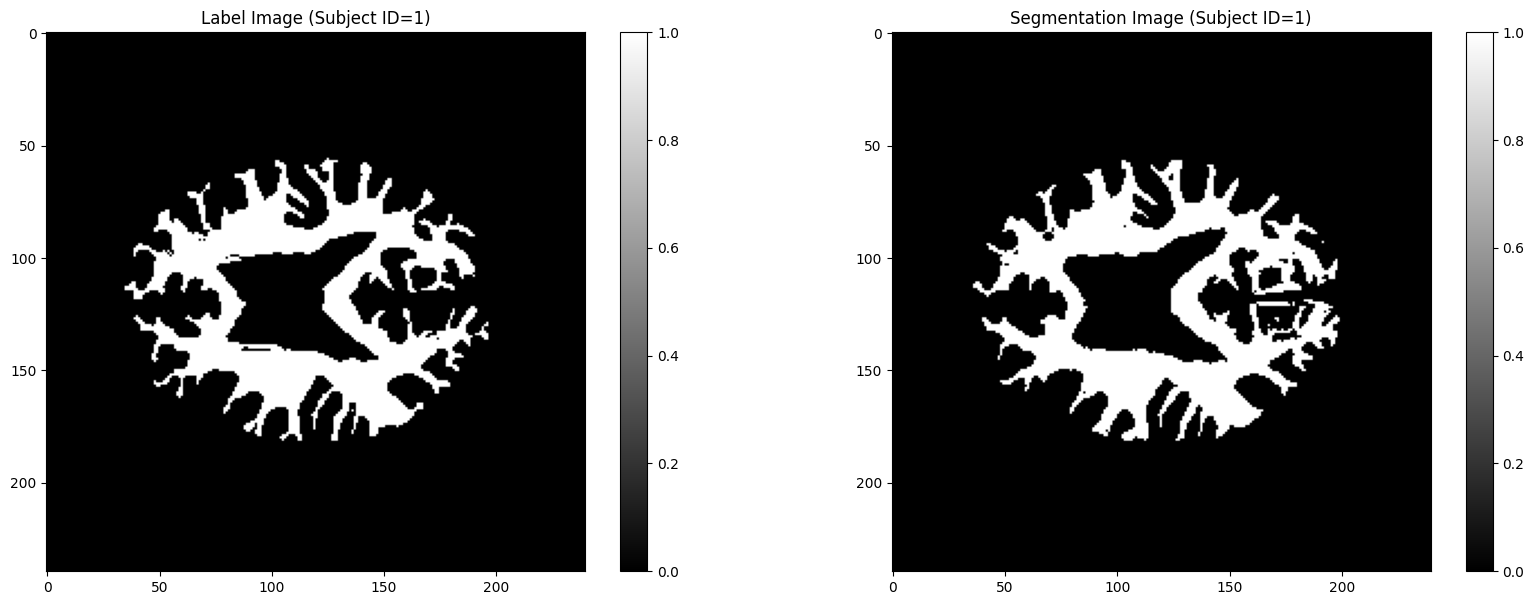

In [64]:
subject_id = 1

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_1 = EM(subject_id, params_init_type='kmeans', modality='multi').fit(n_iterations=20)

segmentation_result_1_CSF   = segmentation_result_1 == 1
segmentation_result_1_GM    = segmentation_result_1 == 2
segmentation_result_1_WM    = segmentation_result_1 == 3

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_1_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_1_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_1_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_WM, segmentation_result_1_WM, subject_id)

2023-10-23 20:12:01.495 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'kmeans'.
2023-10-23 20:12:01.497 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:02.228 | INFO     | __main__:fit:388 - Iterations performed: 4. Displaying the segmentation result..
2023-10-23 20:12:02.247 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this spe

CSF DICE:  0.8843405831799918
GM DICE:  0.7502901629155382
WM DICE:  0.7611225092534397


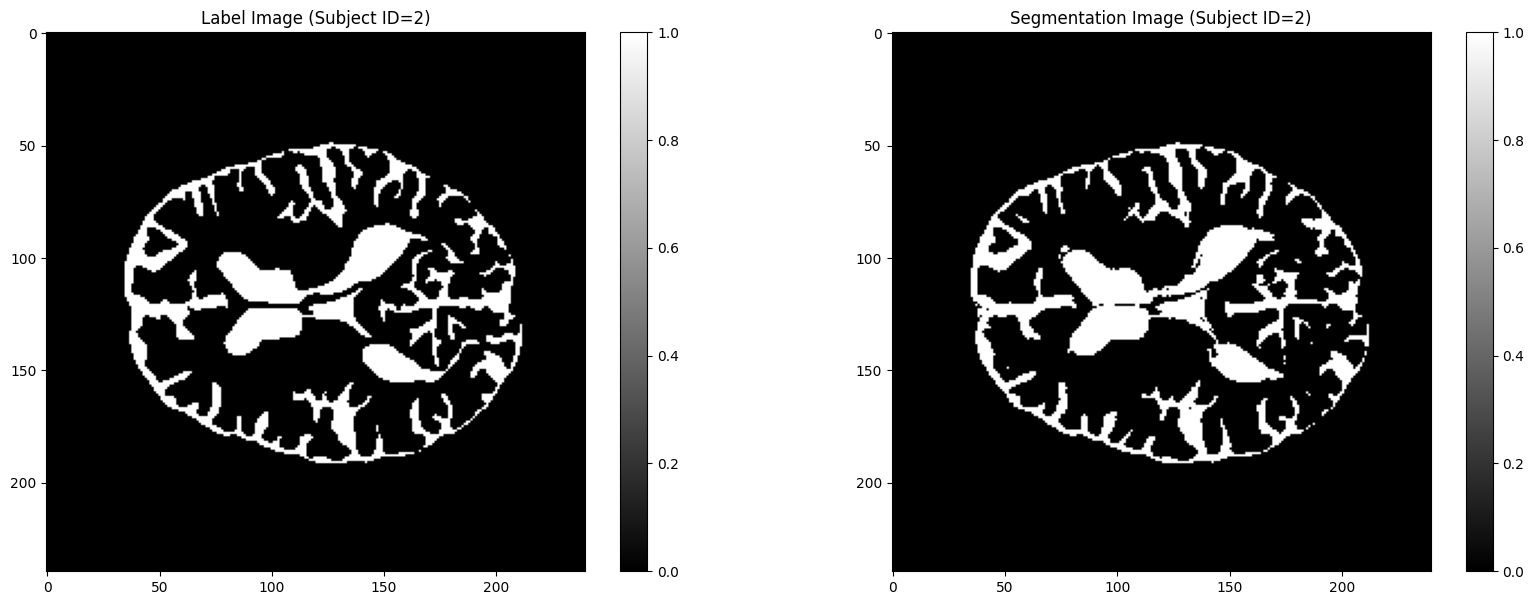

In [65]:
subject_id = 2

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_2 = EM(subject_id, params_init_type='kmeans', modality='multi').fit(n_iterations=20)

segmentation_result_2_CSF   = segmentation_result_2 == 1
segmentation_result_2_GM    = segmentation_result_2 == 2
segmentation_result_2_WM    = segmentation_result_2 == 3

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_2_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_2_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_2_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_CSF, segmentation_result_2_CSF, subject_id)

2023-10-23 20:12:03.060 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'kmeans'.
2023-10-23 20:12:03.062 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:03.955 | INFO     | __main__:fit:388 - Iterations performed: 6. Displaying the segmentation result..
2023-10-23 20:12:03.972 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this spe

CSF DICE:  0.8789285559333958
GM DICE:  0.7991813683903919
WM DICE:  0.8709540942703404


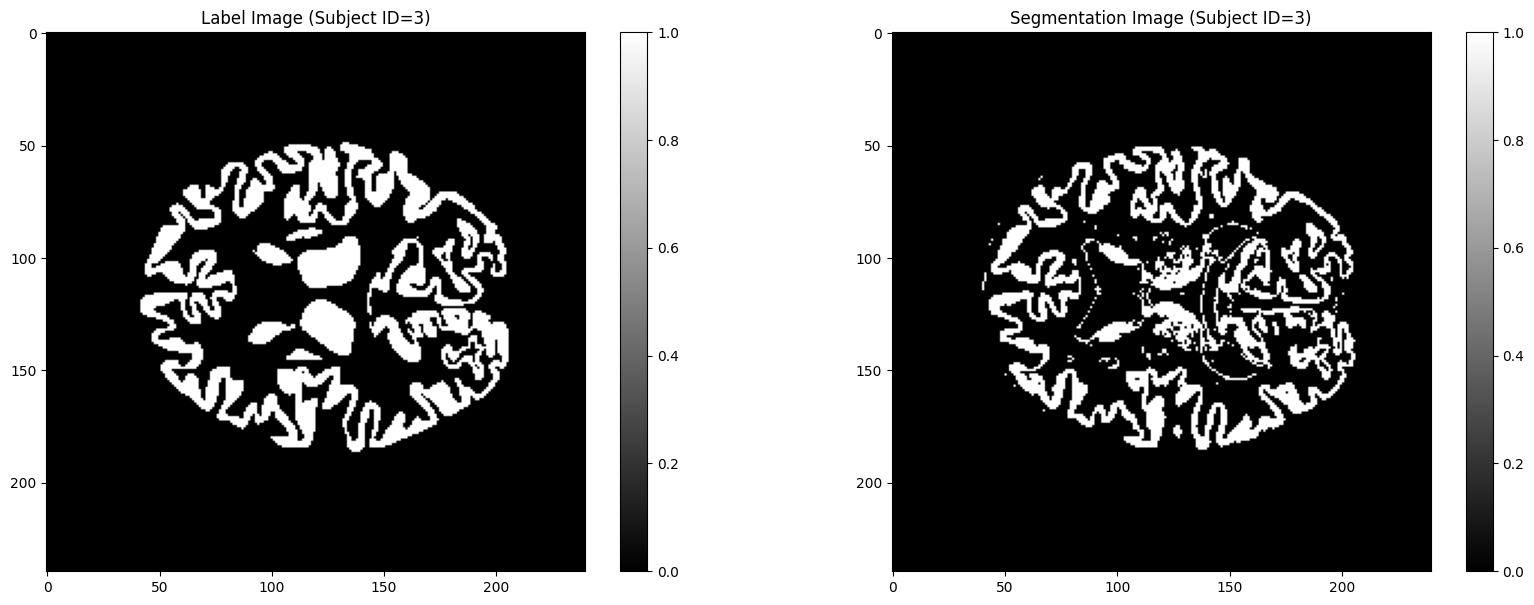

In [66]:
subject_id = 3

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_3 = EM(subject_id, params_init_type='kmeans', modality='multi').fit(n_iterations=20)

segmentation_result_3_CSF   = segmentation_result_3 == 1
segmentation_result_3_GM    = segmentation_result_3 == 2
segmentation_result_3_WM    = segmentation_result_3 == 3

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_3_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_3_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_3_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_GM, segmentation_result_3_GM, subject_id)

2023-10-23 20:12:04.708 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'kmeans'.
2023-10-23 20:12:04.710 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:05.316 | INFO     | __main__:fit:388 - Iterations performed: 4. Displaying the segmentation result..
2023-10-23 20:12:05.333 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this spe

CSF DICE:  0.8978708400389281
GM DICE:  0.7954956531886096
WM DICE:  0.8389592416903219


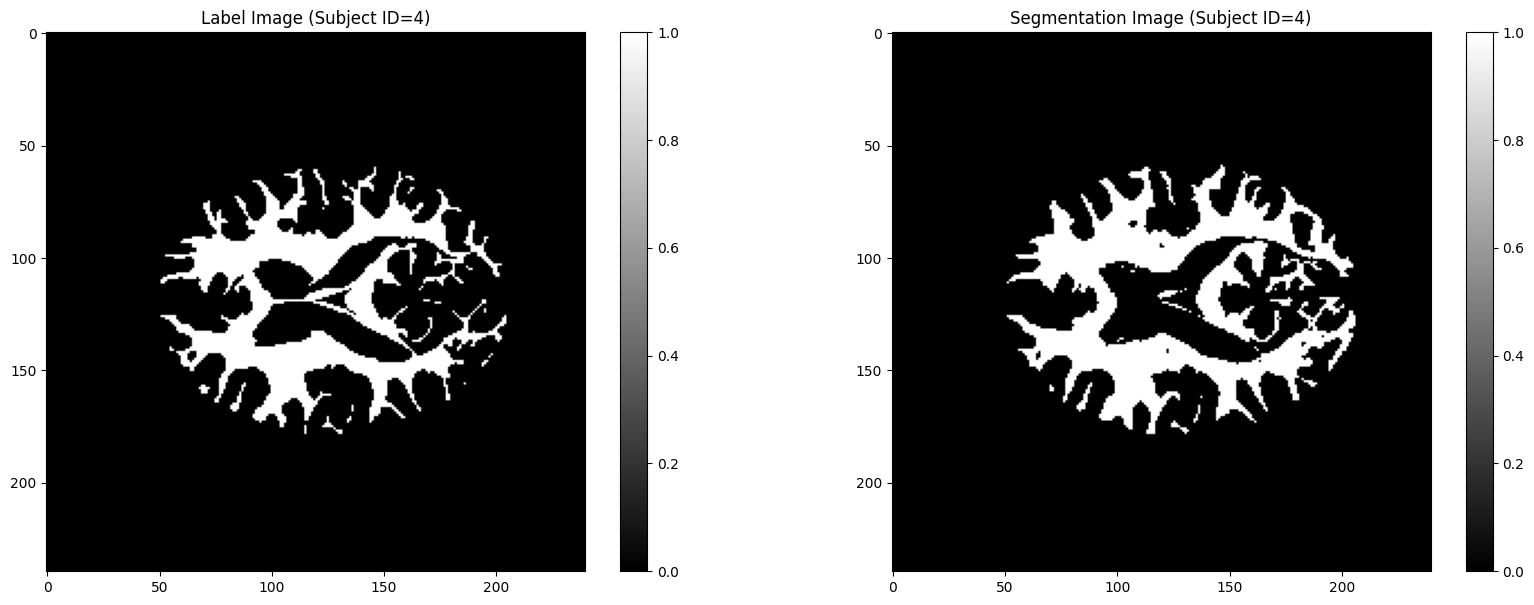

In [67]:
subject_id = 4

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_4 = EM(subject_id, params_init_type='kmeans', modality='multi').fit(n_iterations=20)

segmentation_result_4_CSF   = segmentation_result_4 == 1
segmentation_result_4_GM    = segmentation_result_4 == 2
segmentation_result_4_WM    = segmentation_result_4 == 3

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_4_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_4_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_4_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_WM, segmentation_result_4_WM, subject_id)

2023-10-23 20:12:06.087 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'kmeans'.
2023-10-23 20:12:06.090 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:07.027 | INFO     | __main__:fit:388 - Iterations performed: 6. Displaying the segmentation result..
2023-10-23 20:12:07.045 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this spe

CSF DICE:  0.8686029940879859
GM DICE:  0.8369223204220252
WM DICE:  0.8955829288629474


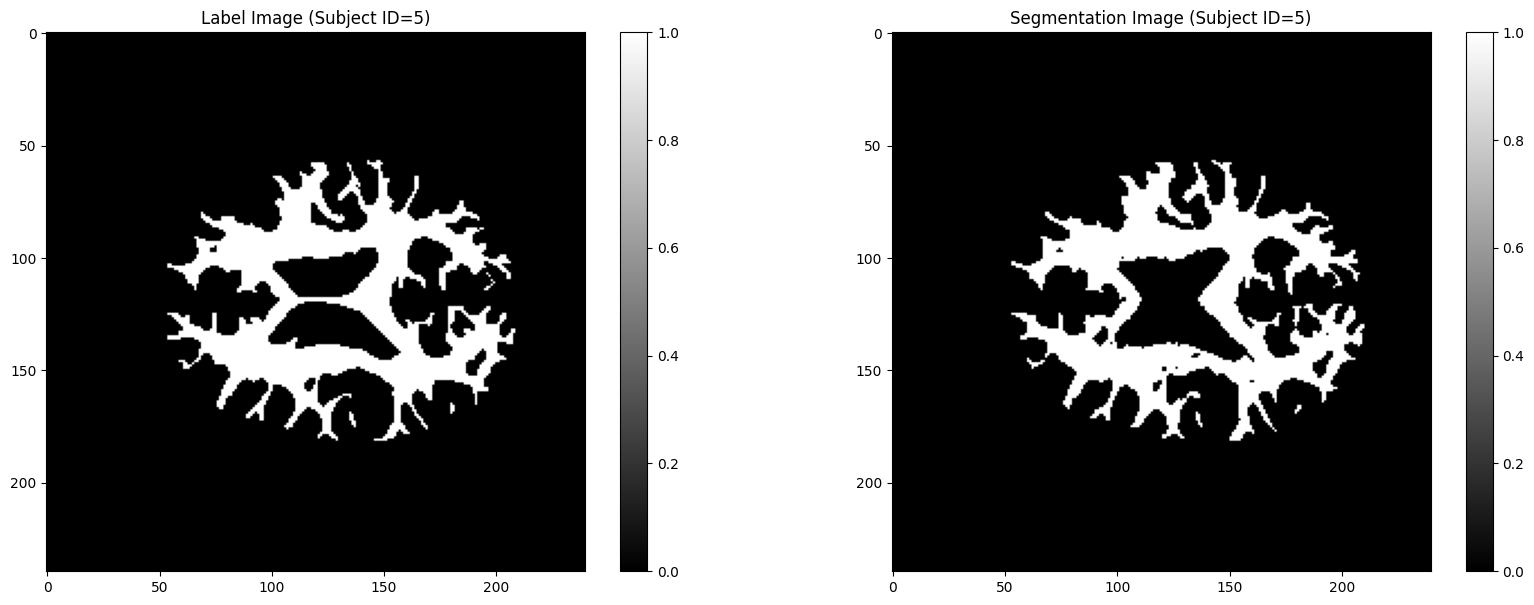

In [68]:
subject_id = 5

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_5 = EM(subject_id, params_init_type='kmeans', modality='multi').fit(n_iterations=20)

segmentation_result_5_CSF   = segmentation_result_5 == 1
segmentation_result_5_GM    = segmentation_result_5 == 2
segmentation_result_5_WM    = segmentation_result_5 == 3

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_5_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_5_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_5_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_WM, segmentation_result_5_WM, subject_id)

In [69]:
print("overall_dice_CSF: ", overall_dice_CSF)
print("overall_dice_GM: ", overall_dice_GM )
print("overall_dice_WM: ", overall_dice_WM )

overall_dice_CSF:  [0.9037845300368287, 0.8843405831799918, 0.8789285559333958, 0.8978708400389281, 0.8686029940879859]
overall_dice_GM:  [0.8014081389460547, 0.7502901629155382, 0.7991813683903919, 0.7954956531886096, 0.8369223204220252]
overall_dice_WM:  [0.8603989456169875, 0.7611225092534397, 0.8709540942703404, 0.8389592416903219, 0.8955829288629474]


In [70]:
mean_csf    = np.mean(overall_dice_CSF)
mean_gm     = np.mean(overall_dice_GM)
mean_wm     = np.mean(overall_dice_WM)

std_csf     = np.std(overall_dice_CSF)
std_gm     = np.std(overall_dice_GM)
std_wm     = np.std(overall_dice_WM)

print("Initialization=KMEANS, T1+T2-FLAIR configuration results...")
print(f"CSF MEAN:\t {mean_csf}, CSF STD:\t {std_csf}")
print(f"GM  MEAN:\t {mean_gm}, GM  STD:\t {std_gm}")
print(f"WM  MEAN:\t {mean_wm}, WM  STD:\t {std_wm}")

# we need to repeat this for init=random T1+T2-FLAIR, init=random T1

Initialization=KMEANS, T1+T2-FLAIR configuration results...
CSF MEAN:	 0.8867055006554262, CSF STD:	 0.012728963006144208
GM  MEAN:	 0.7966595287725239, GM  STD:	 0.02757344396843957
WM  MEAN:	 0.8454035439388073, WM  STD:	 0.045914017912191414


#### 3.2 Evaluating using KMEANS initialization on single modality (T1)

In [71]:
# Placeholders lists to hold all tissues scores from all 5 subjects segmentations for later evaluation
overall_dice_CSF    = []
overall_dice_GM     = []
overall_dice_WM     = []

2023-10-23 20:12:08.018 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'kmeans'.
2023-10-23 20:12:08.021 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:08.350 | INFO     | __main__:fit:388 - Iterations performed: 2. Displaying the segmentation result..
2023-10-23 20:12:08.370 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this spe

CSF DICE:  0.8777228112533829
GM DICE:  0.777201731529185
WM DICE:  0.8585163581677371


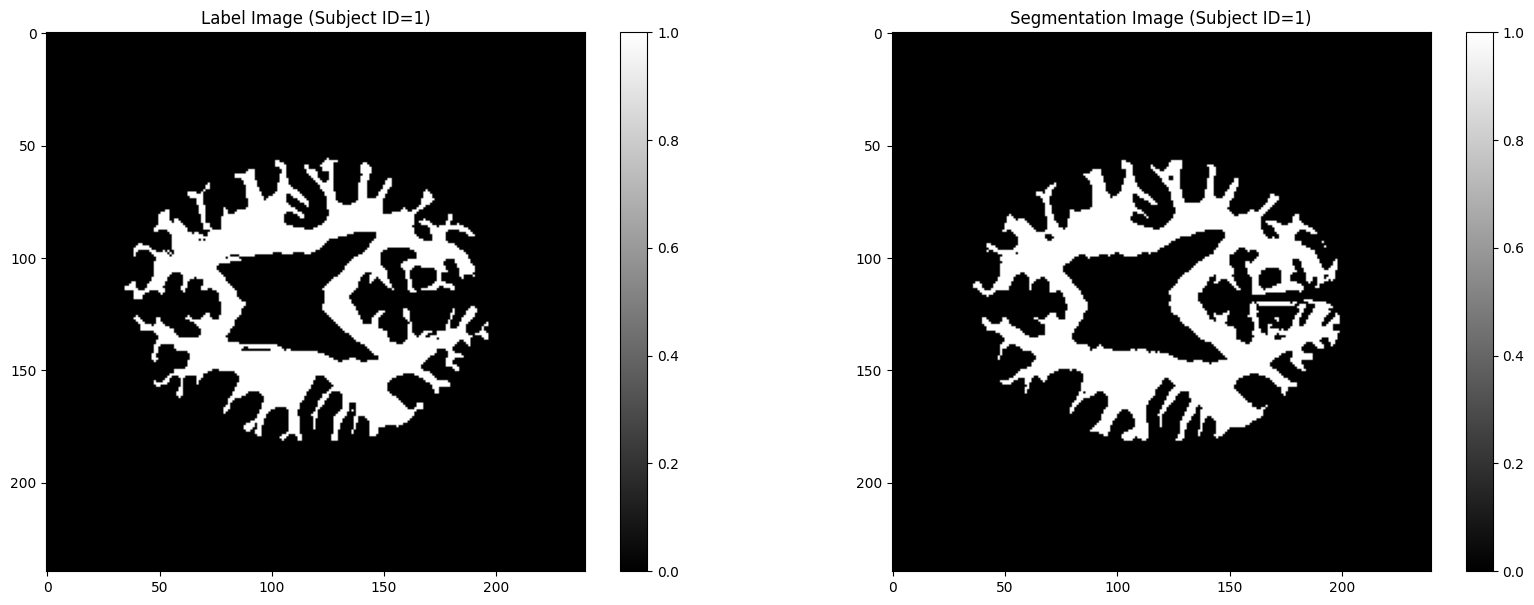

In [72]:
subject_id = 1

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_1 = EM(subject_id, params_init_type='kmeans', modality='single').fit(n_iterations=20)

segmentation_result_1_CSF   = segmentation_result_1 == 1
segmentation_result_1_GM    = segmentation_result_1 == 2
segmentation_result_1_WM    = segmentation_result_1 == 3

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_1_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_1_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_1_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_WM, segmentation_result_1_WM, subject_id)

2023-10-23 20:12:09.177 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'kmeans'.
2023-10-23 20:12:09.178 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:09.548 | INFO     | __main__:fit:388 - Iterations performed: 2. Displaying the segmentation result..
2023-10-23 20:12:09.570 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this spe

CSF DICE:  0.8640533310051677
GM DICE:  0.7422322424811696
WM DICE:  0.7845366724580198


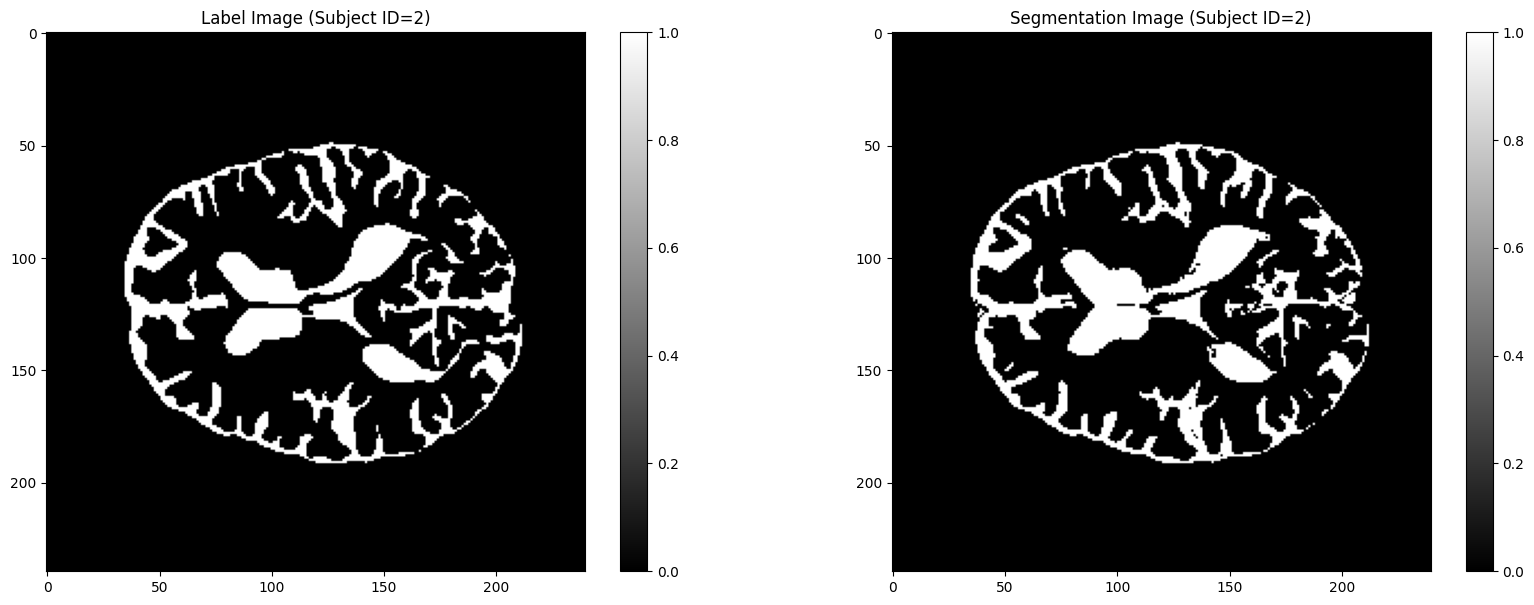

In [73]:
subject_id = 2

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_2 = EM(subject_id, params_init_type='kmeans', modality='single').fit(n_iterations=20)

segmentation_result_2_CSF   = segmentation_result_2 == 1
segmentation_result_2_GM    = segmentation_result_2 == 2
segmentation_result_2_WM    = segmentation_result_2 == 3

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_2_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_2_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_2_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_CSF, segmentation_result_2_CSF, subject_id)

2023-10-23 20:12:10.400 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'kmeans'.
2023-10-23 20:12:10.401 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:11.050 | INFO     | __main__:fit:388 - Iterations performed: 5. Displaying the segmentation result..
2023-10-23 20:12:11.072 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this spe

CSF DICE:  0.8710314539896532
GM DICE:  0.7832769504519126
WM DICE:  0.8752015957898001


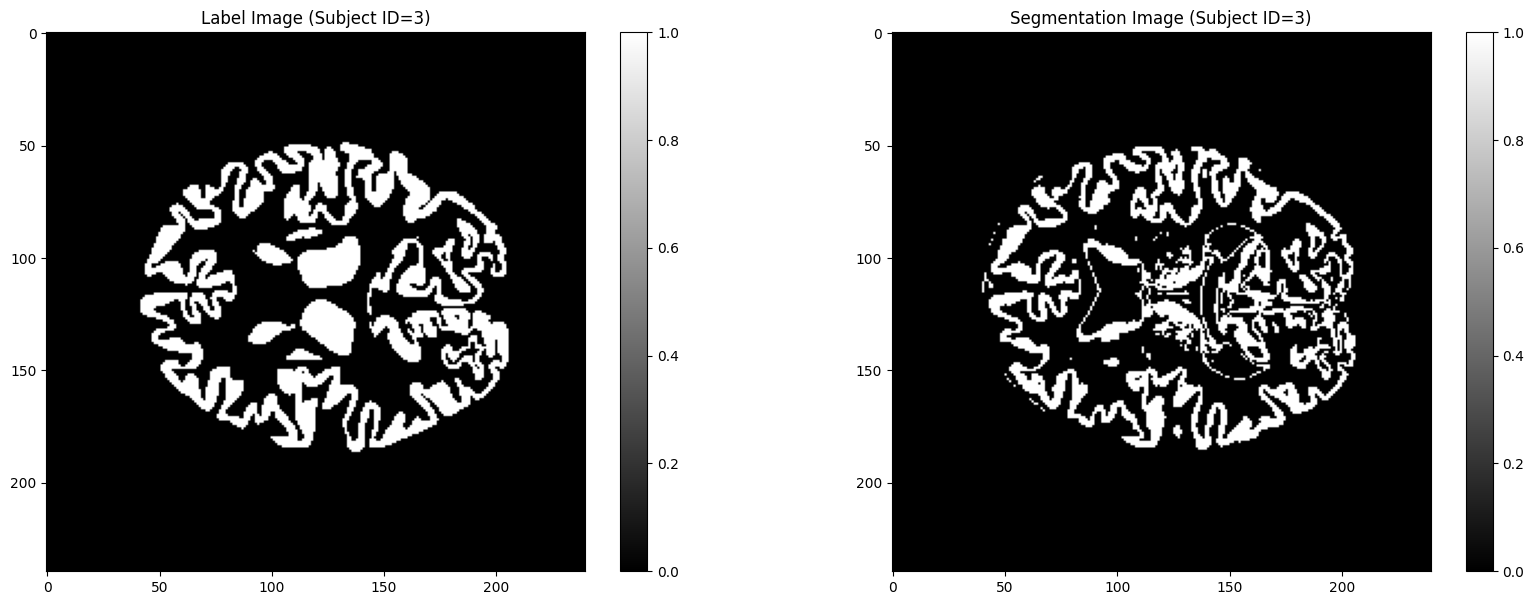

In [74]:
subject_id = 3

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_3 = EM(subject_id, params_init_type='kmeans', modality='single').fit(n_iterations=20)

segmentation_result_3_CSF   = segmentation_result_3 == 1
segmentation_result_3_GM    = segmentation_result_3 == 2
segmentation_result_3_WM    = segmentation_result_3 == 3

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_3_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_3_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_3_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_GM, segmentation_result_3_GM, subject_id)

2023-10-23 20:12:11.820 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'kmeans'.
2023-10-23 20:12:11.822 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:12.033 | INFO     | __main__:fit:388 - Iterations performed: 1. Displaying the segmentation result..
2023-10-23 20:12:12.052 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this spe

CSF DICE:  0.8786262867759261
GM DICE:  0.7777787860912994
WM DICE:  0.8336342744582718


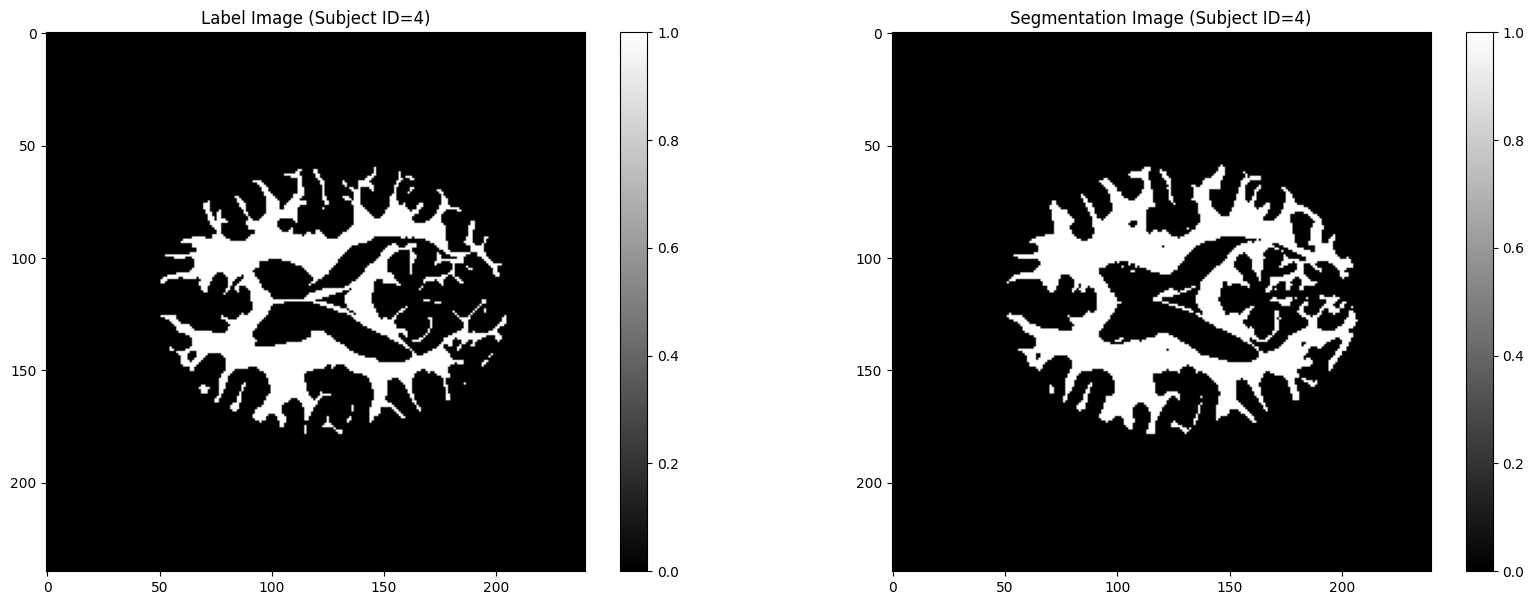

In [75]:
subject_id = 4

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_4 = EM(subject_id, params_init_type='kmeans', modality='single').fit(n_iterations=20)

segmentation_result_4_CSF   = segmentation_result_4 == 1
segmentation_result_4_GM    = segmentation_result_4 == 2
segmentation_result_4_WM    = segmentation_result_4 == 3

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_4_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_4_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_4_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_WM, segmentation_result_4_WM, subject_id)

2023-10-23 20:12:12.800 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'kmeans'.
2023-10-23 20:12:12.802 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:13.125 | INFO     | __main__:fit:388 - Iterations performed: 2. Displaying the segmentation result..
2023-10-23 20:12:13.145 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this spe

CSF DICE:  0.8595897094444561
GM DICE:  0.8296103304791929
WM DICE:  0.8855797826607532


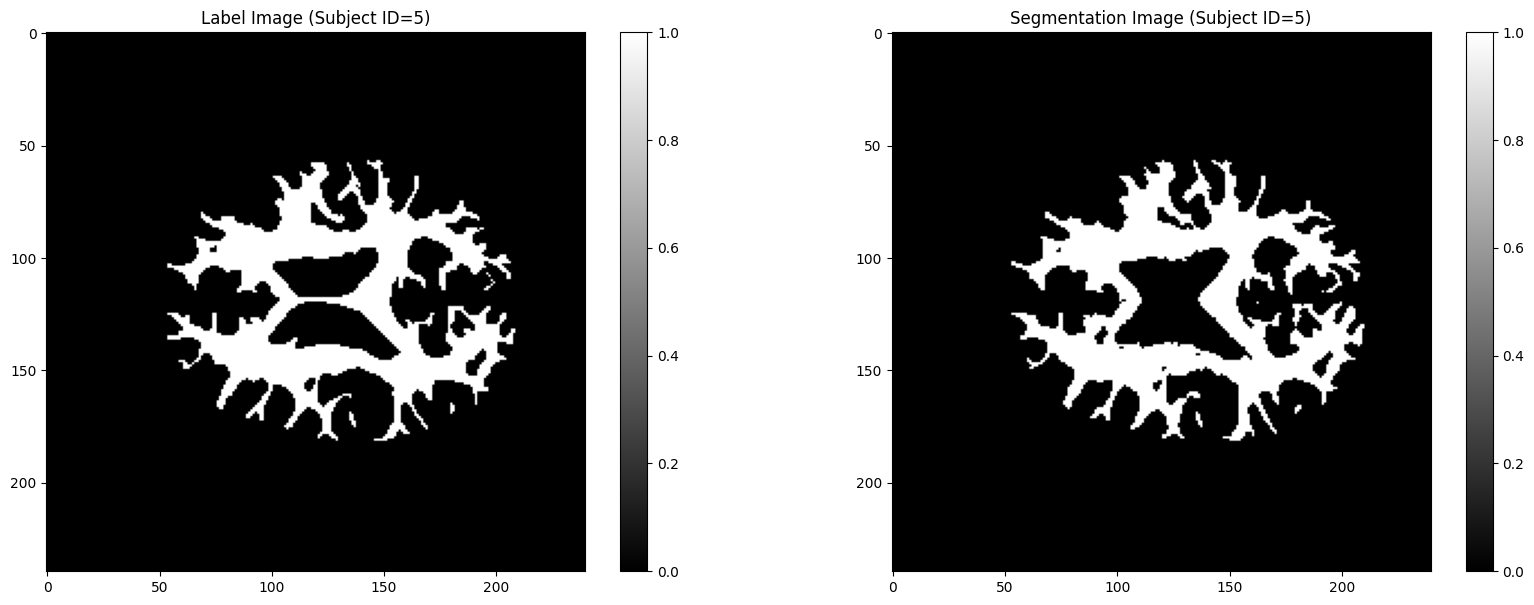

In [76]:
subject_id = 5

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_5 = EM(subject_id, params_init_type='kmeans', modality='single').fit(n_iterations=20)

segmentation_result_5_CSF   = segmentation_result_5 == 1
segmentation_result_5_GM    = segmentation_result_5 == 2
segmentation_result_5_WM    = segmentation_result_5 == 3

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_5_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_5_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_5_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_WM, segmentation_result_5_WM, subject_id)

In [77]:
print("overall_dice_CSF: ", overall_dice_CSF)
print("overall_dice_GM: ", overall_dice_GM )
print("overall_dice_WM: ", overall_dice_WM )

overall_dice_CSF:  [0.8777228112533829, 0.8640533310051677, 0.8710314539896532, 0.8786262867759261, 0.8595897094444561]
overall_dice_GM:  [0.777201731529185, 0.7422322424811696, 0.7832769504519126, 0.7777787860912994, 0.8296103304791929]
overall_dice_WM:  [0.8585163581677371, 0.7845366724580198, 0.8752015957898001, 0.8336342744582718, 0.8855797826607532]


In [78]:
mean_csf    = np.mean(overall_dice_CSF)
mean_gm     = np.mean(overall_dice_GM)
mean_wm     = np.mean(overall_dice_WM)

std_csf     = np.std(overall_dice_CSF)
std_gm     = np.std(overall_dice_GM)
std_wm     = np.std(overall_dice_WM)

print("Initialization=KMEANS, T1 configuration results...")
print(f"CSF MEAN:\t {mean_csf}, CSF STD:\t {std_csf}")
print(f"GM  MEAN:\t {mean_gm}, GM  STD:\t {std_gm}")
print(f"WM  MEAN:\t {mean_wm}, WM  STD:\t {std_wm}")

Initialization=KMEANS, T1 configuration results...
CSF MEAN:	 0.8702047184937172, CSF STD:	 0.007465199365124343
GM  MEAN:	 0.7820200082065518, GM  STD:	 0.02789512048516898
WM  MEAN:	 0.8474937367069163, WM  STD:	 0.036042883258375846


#### 3.3 Evaluating using random initialization on multi-modality (T1+T2-FLAIR)

In [79]:
# Placeholders lists to hold all tissues scores from all 5 subjects segmentations for later evaluation
overall_dice_CSF    = []
overall_dice_GM     = []
overall_dice_WM     = []

2023-10-23 20:12:14.071 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'random'.
2023-10-23 20:12:14.073 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:17.281 | INFO     | __main__:fit:388 - Iterations performed: 19. Displaying the segmentation result..
2023-10-23 20:12:17.298 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this sp

CSF DICE:  0.00024359052432858876
GM DICE:  0.0003195077214365825
WM DICE:  0.42937755672214545


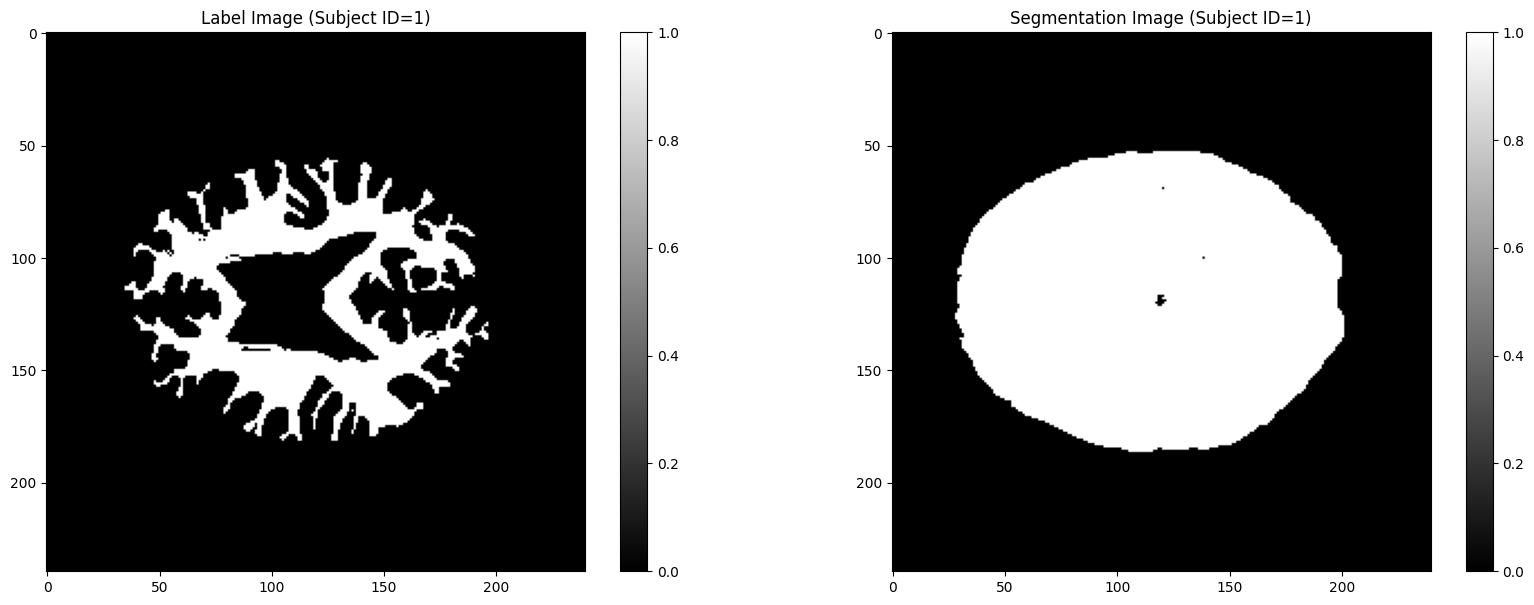

In [80]:
subject_id = 1

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_1 = EM(subject_id, params_init_type='random', modality='multi').fit(n_iterations=20)

segmentation_result_1_CSF   = segmentation_result_1 == 1
segmentation_result_1_GM    = segmentation_result_1 == 2
segmentation_result_1_WM    = segmentation_result_1 == 3

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_1_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_1_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_1_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_WM, segmentation_result_1_WM, subject_id)

2023-10-23 20:12:17.933 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'random'.
2023-10-23 20:12:17.936 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:20.886 | INFO     | __main__:fit:388 - Iterations performed: 20. Displaying the segmentation result..
2023-10-23 20:12:20.904 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this sp

CSF DICE:  0.014904985482568606
GM DICE:  0.6430098801807657
WM DICE:  0.7367580234334901


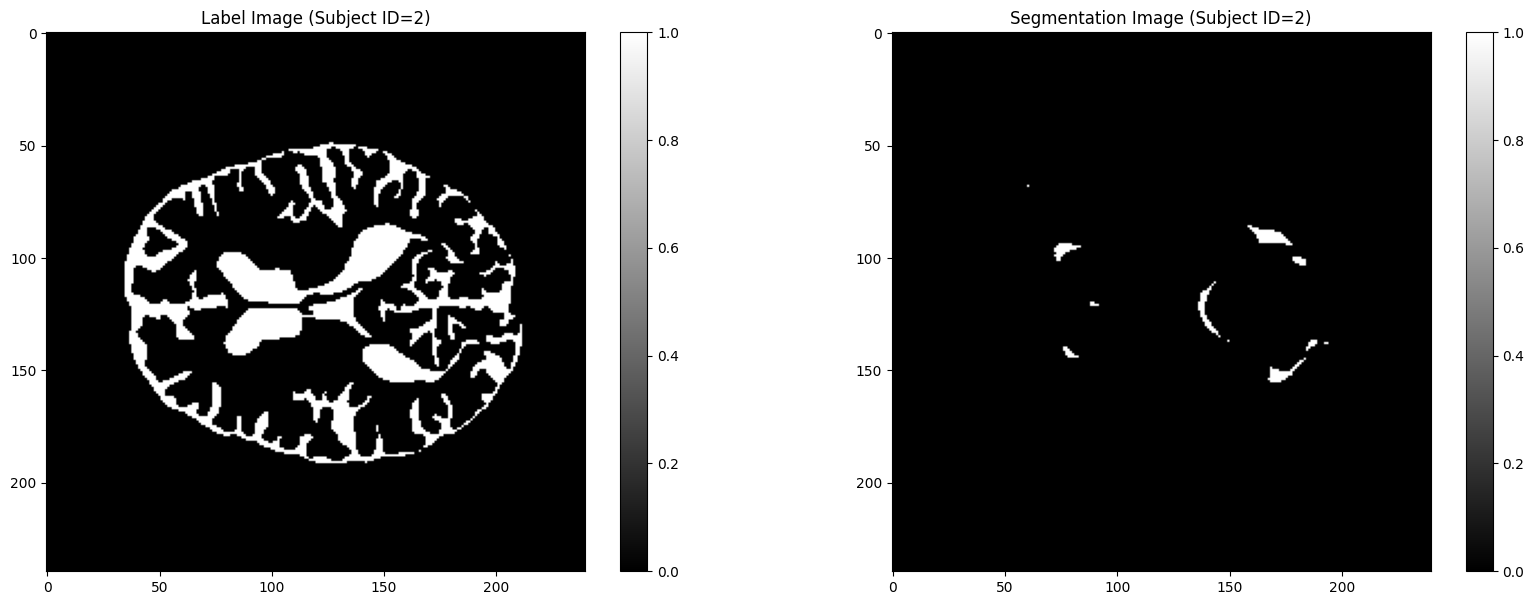

In [81]:
subject_id = 2

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_2 = EM(subject_id, params_init_type='random', modality='multi').fit(n_iterations=20)

segmentation_result_2_CSF   = segmentation_result_2 == 3
segmentation_result_2_GM    = segmentation_result_2 == 2
segmentation_result_2_WM    = segmentation_result_2 == 1

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_2_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_2_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_2_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_CSF, segmentation_result_2_CSF, subject_id)

2023-10-23 20:12:21.477 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'random'.
2023-10-23 20:12:21.478 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:22.968 | INFO     | __main__:fit:388 - Iterations performed: 9. Displaying the segmentation result..
2023-10-23 20:12:22.990 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this spe

CSF DICE:  0.4923577093489456
GM DICE:  0.0
WM DICE:  0.021649345773204567


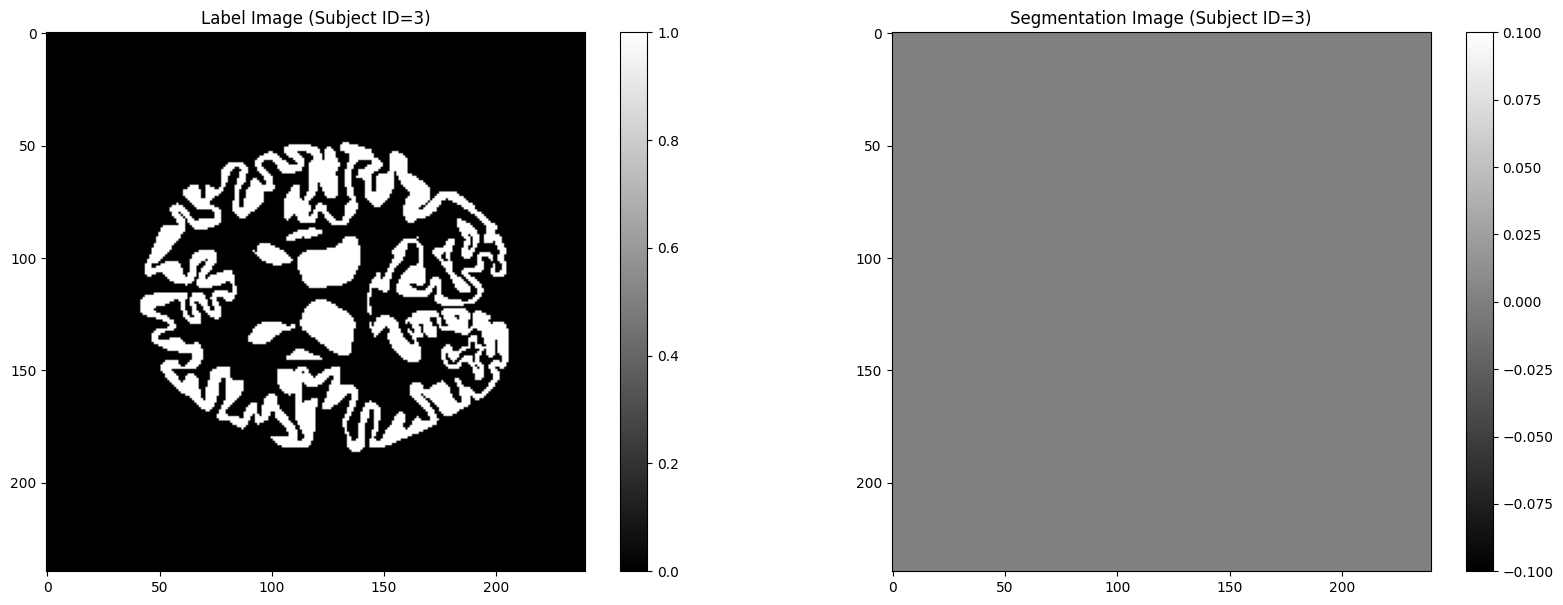

In [82]:
subject_id = 3

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_3 = EM(subject_id, params_init_type='random', modality='multi').fit(n_iterations=20)

segmentation_result_3_CSF   = segmentation_result_3 == 1
segmentation_result_3_GM    = segmentation_result_3 == 2
segmentation_result_3_WM    = segmentation_result_3 == 3

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_3_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_3_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_3_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_GM, segmentation_result_3_GM, subject_id)

2023-10-23 20:12:23.937 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'random'.
2023-10-23 20:12:23.938 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:24.951 | INFO     | __main__:fit:388 - Iterations performed: 5. Displaying the segmentation result..
2023-10-23 20:12:24.968 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this spe

CSF DICE:  0.8620083339354703
GM DICE:  0.00574795560916177
WM DICE:  0.59891684147047


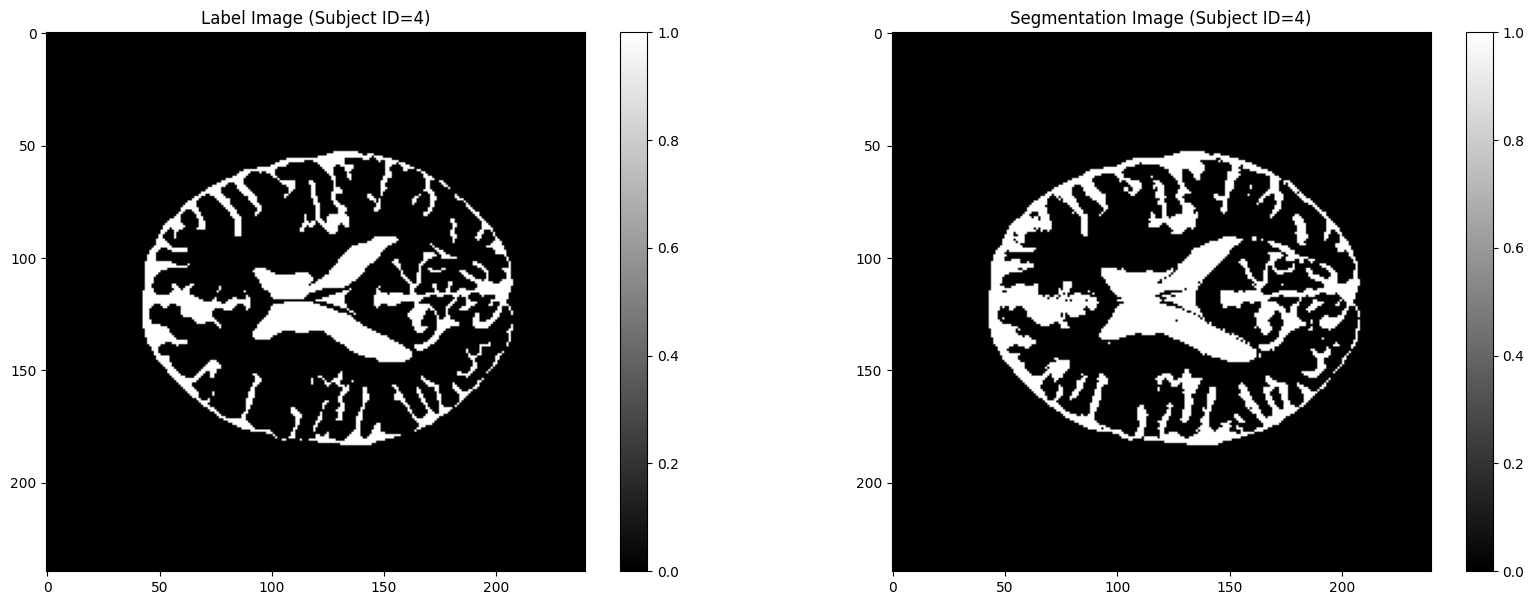

In [83]:
subject_id = 4

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_4 = EM(subject_id, params_init_type='random', modality='multi').fit(n_iterations=20)

segmentation_result_4_CSF   = segmentation_result_4 == 2
segmentation_result_4_GM    = segmentation_result_4 == 1
segmentation_result_4_WM    = segmentation_result_4 == 3

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_4_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_4_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_4_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_CSF, segmentation_result_4_CSF, subject_id)

2023-10-23 20:12:25.736 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'random'.
2023-10-23 20:12:25.738 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:26.577 | INFO     | __main__:fit:388 - Iterations performed: 3. Displaying the segmentation result..
2023-10-23 20:12:26.601 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this spe

CSF DICE:  0.006277347434172405
GM DICE:  0.617545822598445
WM DICE:  0.00021235609082771758


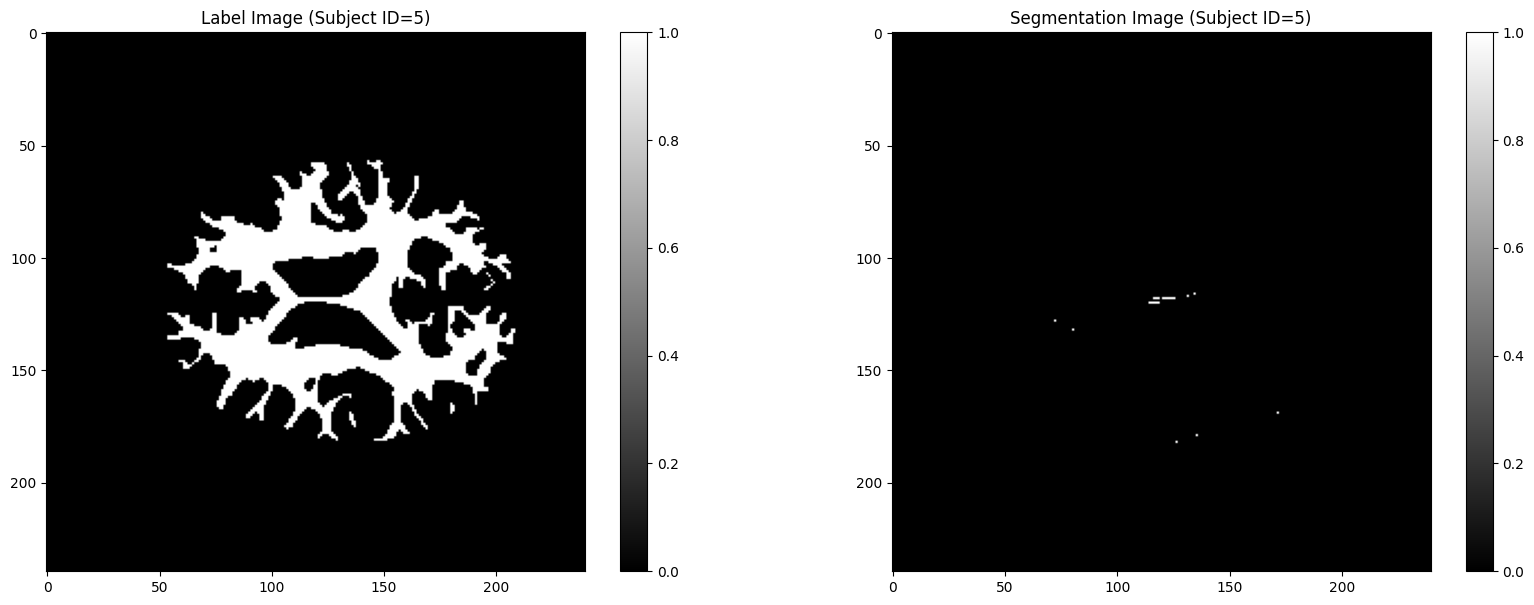

In [84]:
subject_id = 5

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_5 = EM(subject_id, params_init_type='random', modality='multi').fit(n_iterations=20)

segmentation_result_5_CSF   = segmentation_result_5 == 1
segmentation_result_5_GM    = segmentation_result_5 == 2
segmentation_result_5_WM    = segmentation_result_5 == 3

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_5_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_5_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_5_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_WM, segmentation_result_5_WM, subject_id)

In [85]:
print("overall_dice_CSF: ", overall_dice_CSF)
print("overall_dice_GM: ", overall_dice_GM )
print("overall_dice_WM: ", overall_dice_WM )

overall_dice_CSF:  [0.00024359052432858876, 0.014904985482568606, 0.4923577093489456, 0.8620083339354703, 0.006277347434172405]
overall_dice_GM:  [0.0003195077214365825, 0.6430098801807657, 0.0, 0.00574795560916177, 0.617545822598445]
overall_dice_WM:  [0.42937755672214545, 0.7367580234334901, 0.021649345773204567, 0.59891684147047, 0.00021235609082771758]


In [86]:
mean_csf    = np.mean(overall_dice_CSF)
mean_gm     = np.mean(overall_dice_GM)
mean_wm     = np.mean(overall_dice_WM)

std_csf     = np.std(overall_dice_CSF)
std_gm     = np.std(overall_dice_GM)
std_wm     = np.std(overall_dice_WM)

print("Initialization=Random, T1+T2-FLAIR configuration results...")
print(f"CSF MEAN:\t {mean_csf}, CSF STD:\t {std_csf}")
print(f"GM  MEAN:\t {mean_gm}, GM  STD:\t {std_gm}")
print(f"WM  MEAN:\t {mean_wm}, WM  STD:\t {std_wm}")

Initialization=Random, T1+T2-FLAIR configuration results...
CSF MEAN:	 0.27515839334509706, CSF STD:	 0.34847536429643305
GM  MEAN:	 0.2533246332219618, GM  STD:	 0.30789311168408245
WM  MEAN:	 0.35738282469802757, WM  STD:	 0.29924410658493444


#### 3.4 Evaluating using random initialization on single modality (T1)

In [87]:
# Placeholders lists to hold all tissues scores from all 5 subjects segmentations for later evaluation
overall_dice_CSF    = []
overall_dice_GM     = []
overall_dice_WM     = []

2023-10-23 20:12:27.758 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'random'.
2023-10-23 20:12:27.759 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:30.448 | INFO     | __main__:fit:388 - Iterations performed: 20. Displaying the segmentation result..
2023-10-23 20:12:30.482 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this sp

CSF DICE:  0.6011449647033266
GM DICE:  0.003461397262349236
WM DICE:  0.6917290163214541


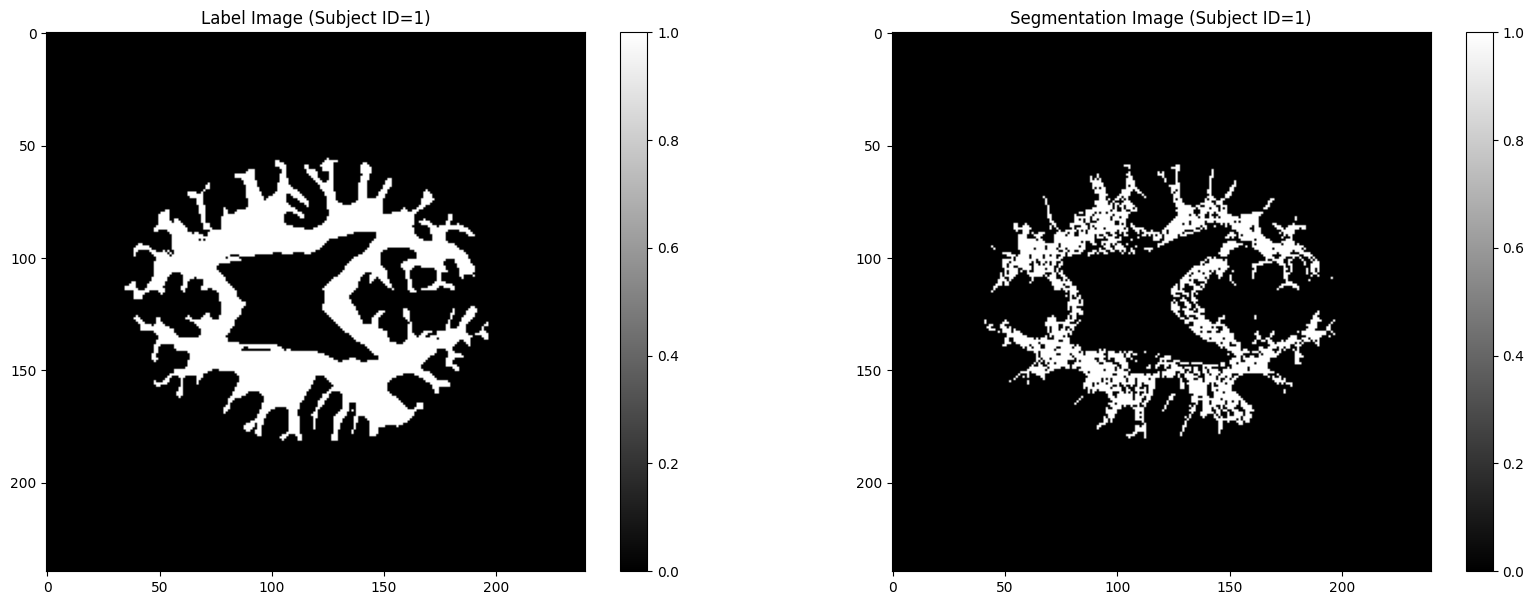

In [88]:
subject_id = 1

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_1 = EM(subject_id, params_init_type='random', modality='single').fit(n_iterations=20)

segmentation_result_1_CSF   = segmentation_result_1 == 1
segmentation_result_1_GM    = segmentation_result_1 == 2
segmentation_result_1_WM    = segmentation_result_1 == 3

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_1_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_1_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_1_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_WM, segmentation_result_1_WM, subject_id)

2023-10-23 20:12:31.161 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'random'.
2023-10-23 20:12:31.163 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:32.369 | INFO     | __main__:fit:388 - Iterations performed: 6. Displaying the segmentation result..
2023-10-23 20:12:32.400 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this spe

CSF DICE:  0.8228789259596562
GM DICE:  0.6738874048970601
WM DICE:  0.7877145813220117


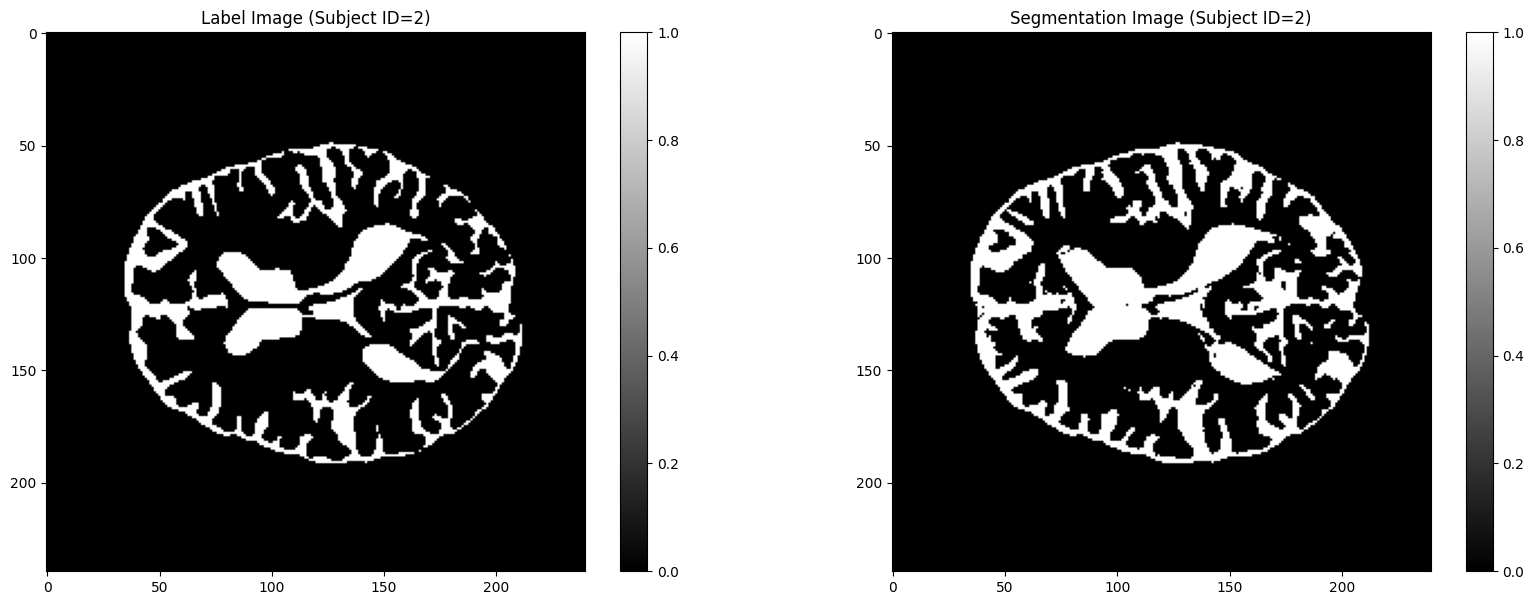

In [89]:
subject_id = 2

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_2 = EM(subject_id, params_init_type='random', modality='single').fit(n_iterations=20)

segmentation_result_2_CSF   = segmentation_result_2 == 3
segmentation_result_2_GM    = segmentation_result_2 == 2
segmentation_result_2_WM    = segmentation_result_2 == 1

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_2_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_2_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_2_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_CSF, segmentation_result_2_CSF, subject_id)

2023-10-23 20:12:33.205 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'random'.
2023-10-23 20:12:33.206 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:35.190 | INFO     | __main__:fit:388 - Iterations performed: 20. Displaying the segmentation result..
2023-10-23 20:12:35.206 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this sp

CSF DICE:  9.159606136935512e-05
GM DICE:  0.5853952163350195
WM DICE:  0.5553535824334884


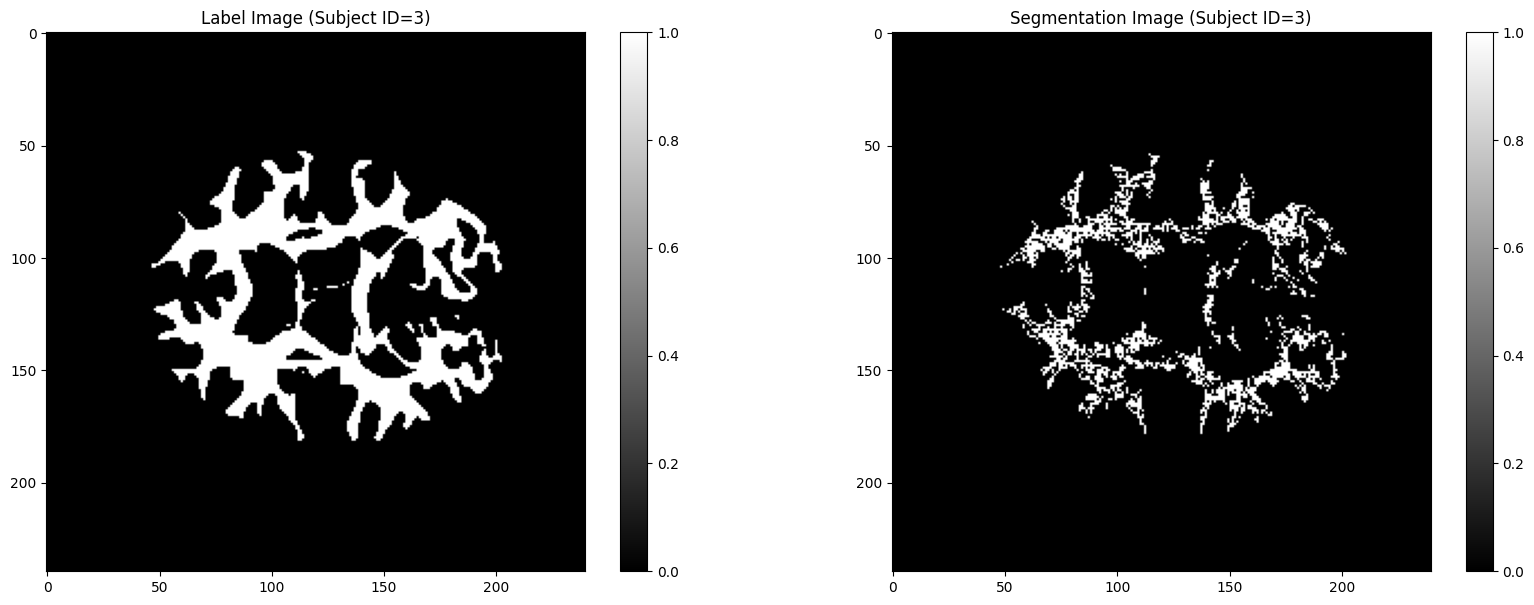

In [90]:
subject_id = 3

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_3 = EM(subject_id, params_init_type='random', modality='single').fit(n_iterations=20)

segmentation_result_3_CSF   = segmentation_result_3 == 3
segmentation_result_3_GM    = segmentation_result_3 == 2
segmentation_result_3_WM    = segmentation_result_3 == 1

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_3_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_3_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_3_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_WM, segmentation_result_3_WM, subject_id)

2023-10-23 20:12:35.876 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'random'.
2023-10-23 20:12:35.877 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:37.851 | INFO     | __main__:fit:388 - Iterations performed: 20. Displaying the segmentation result..
2023-10-23 20:12:37.871 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this sp

CSF DICE:  0.8747886868562185
GM DICE:  0.6309924426337352
WM DICE:  0.7810954290417532


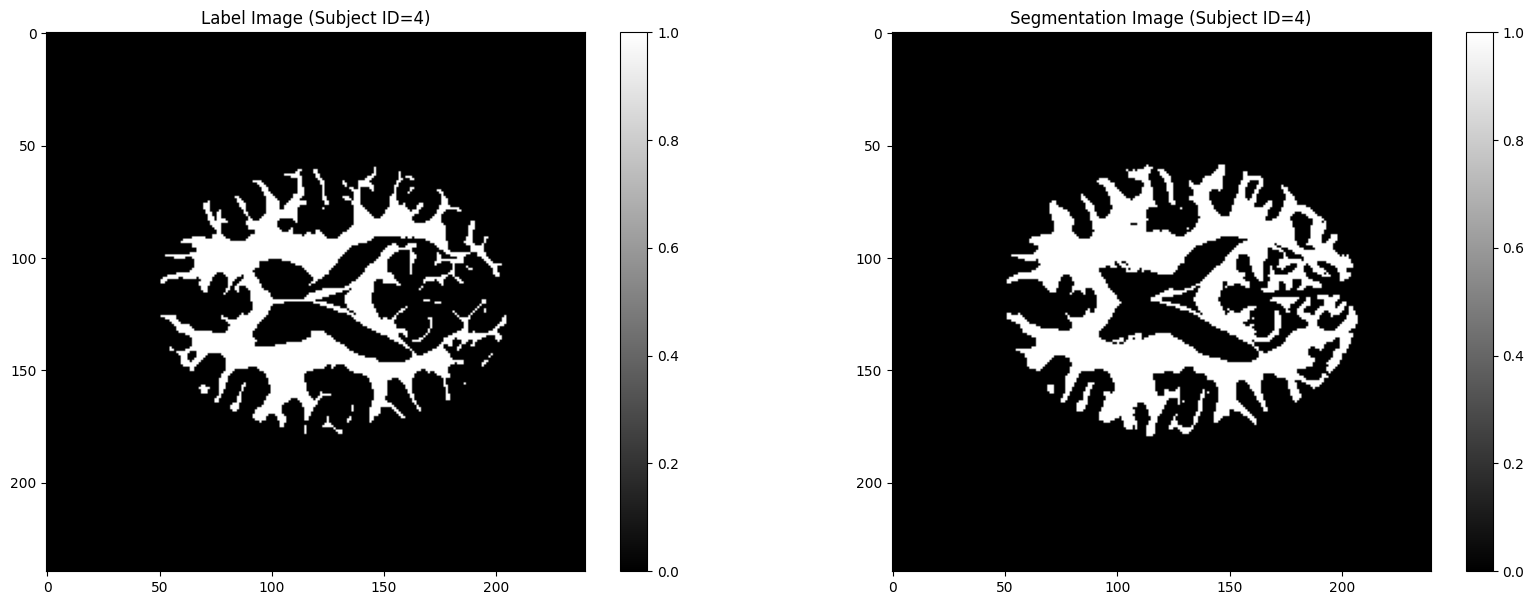

In [91]:
subject_id = 4

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_4 = EM(subject_id, params_init_type='random', modality='single').fit(n_iterations=20)

segmentation_result_4_CSF   = segmentation_result_4 == 1
segmentation_result_4_GM    = segmentation_result_4 == 2
segmentation_result_4_WM    = segmentation_result_4 == 3

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_4_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_4_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_4_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_WM, segmentation_result_4_WM, subject_id)

2023-10-23 20:12:38.561 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'random'.
2023-10-23 20:12:38.562 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_20880\61860348.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-23 20:12:40.648 | INFO     | __main__:fit:388 - Iterations performed: 20. Displaying the segmentation result..
2023-10-23 20:12:40.666 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this sp

CSF DICE:  8.990110878033488e-05
GM DICE:  0.677844922418951
WM DICE:  0.6153573087905628


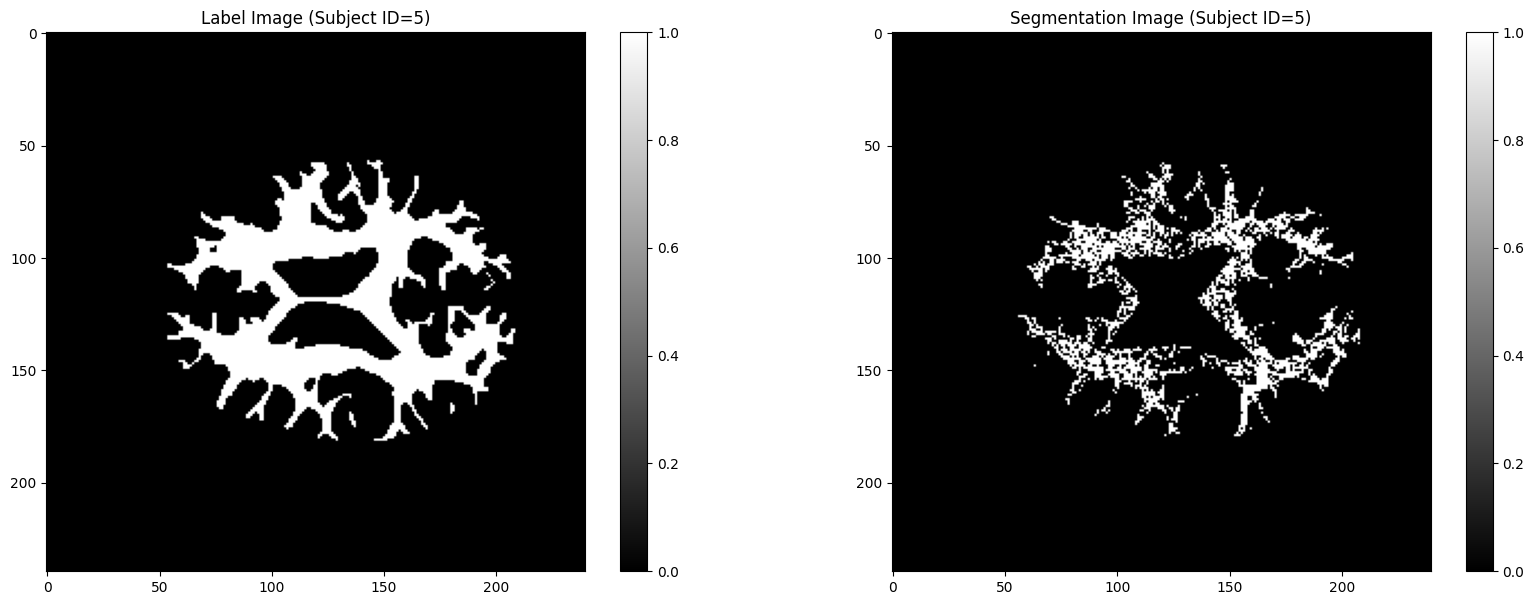

In [92]:
subject_id = 5

data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{subject_id}')

labels_nifti, _ = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))
segmentation_result_5 = EM(subject_id, params_init_type='random', modality='single').fit(n_iterations=20)

segmentation_result_5_CSF   = segmentation_result_5 == 1
segmentation_result_5_GM    = segmentation_result_5 == 3
segmentation_result_5_WM    = segmentation_result_5 == 2

labels_nifti_CSF            = labels_nifti == 1
labels_nifti_GM             = labels_nifti == 2
labels_nifti_WM             = labels_nifti == 3

csf_dice    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_result_5_CSF)
gm_dice     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_result_5_GM)
wm_dice     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_result_5_WM)

# appending to a global lists for later computation
overall_dice_CSF.append(csf_dice)
overall_dice_GM.append(gm_dice)
overall_dice_WM.append(wm_dice)

print("CSF DICE: ", csf_dice)
print("GM DICE: ", gm_dice)
print("WM DICE: ", wm_dice)

NM.show_label_seg_nifti(labels_nifti_WM, segmentation_result_5_WM, subject_id)

In [93]:
print("overall_dice_CSF: ", overall_dice_CSF)
print("overall_dice_GM: ", overall_dice_GM )
print("overall_dice_WM: ", overall_dice_WM )

overall_dice_CSF:  [0.6011449647033266, 0.8228789259596562, 9.159606136935512e-05, 0.8747886868562185, 8.990110878033488e-05]
overall_dice_GM:  [0.003461397262349236, 0.6738874048970601, 0.5853952163350195, 0.6309924426337352, 0.677844922418951]
overall_dice_WM:  [0.6917290163214541, 0.7877145813220117, 0.5553535824334884, 0.7810954290417532, 0.6153573087905628]


In [94]:
mean_csf    = np.mean(overall_dice_CSF)
mean_gm     = np.mean(overall_dice_GM)
mean_wm     = np.mean(overall_dice_WM)

std_csf     = np.std(overall_dice_CSF)
std_gm     = np.std(overall_dice_GM)
std_wm     = np.std(overall_dice_WM)

print("Initialization=Random, T1 configuration results...")
print(f"CSF MEAN:\t {mean_csf}, CSF STD:\t {std_csf}")
print(f"GM  MEAN:\t {mean_gm}, GM  STD:\t {std_gm}")
print(f"WM  MEAN:\t {mean_wm}, WM  STD:\t {std_wm}")

# we need to repeat this for init=random T1+T2-FLAIR, init=random T1

Initialization=Random, T1 configuration results...
CSF MEAN:	 0.4597988149378702, CSF STD:	 0.38644158870623824
GM  MEAN:	 0.514316276709423, GM  STD:	 0.257620967363547
WM  MEAN:	 0.6862499835818541, WM  STD:	 0.09108279979389956


### 4. Visualization

2023-10-25 09:35:36.568 | INFO     | __main__:initialize_parameters:164 - Successfully initialized model parameters using 'kmeans'.
2023-10-25 09:35:36.568 | INFO     | __main__:fit:366 - Fitting the algorithm with 20 iterations.
C:\Users\abdal\AppData\Local\Temp\ipykernel_38248\509627734.py:284: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.log(np.sum(alpha[k] * w[:, k] for k in range(self.K))))
2023-10-25 09:35:37.597 | INFO     | __main__:fit:388 - Iterations performed: 4. Displaying the segmentation result..
2023-10-25 09:35:37.628 | WARNING  | __main__:correct_pred_labels:290 - 
 `correct_pred_labels` function modifies the labels based on prior knowledge for only the 5 subjects, and not standardised to all brain tissue segmentation 
 mask labels. It is not mandatory to correct the prediction labels, as it is implemented for this sp

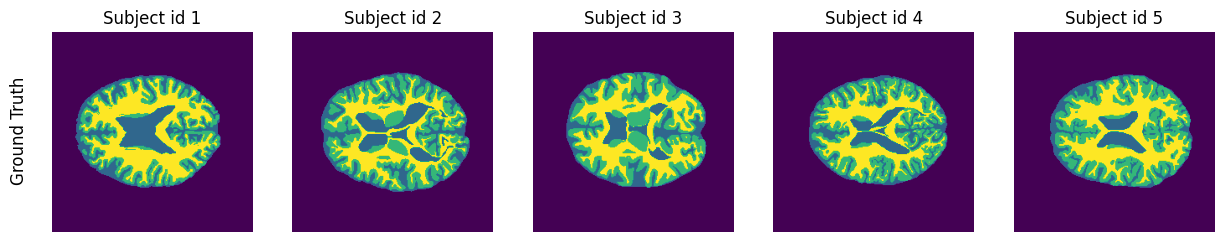

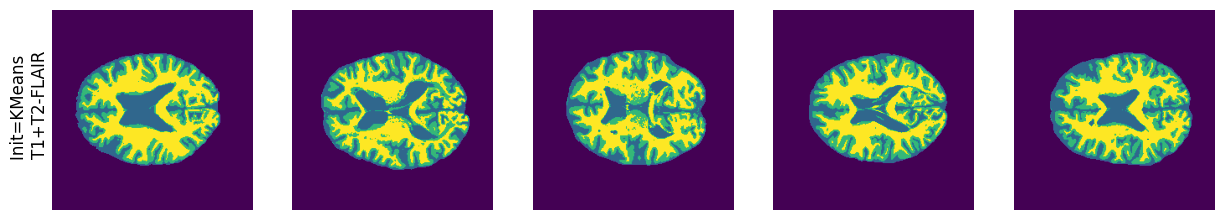

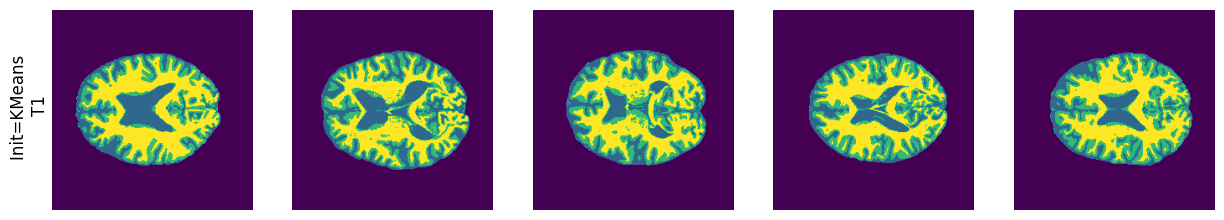

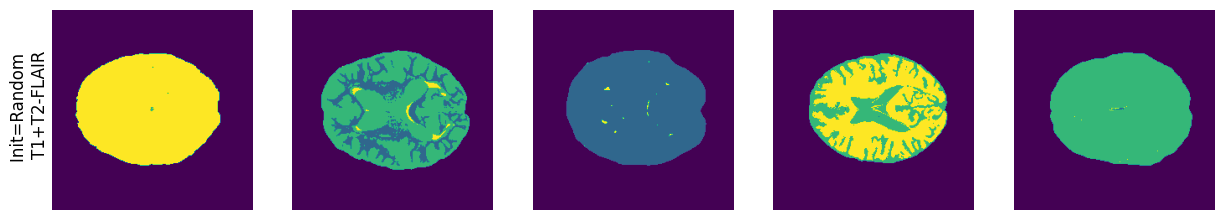

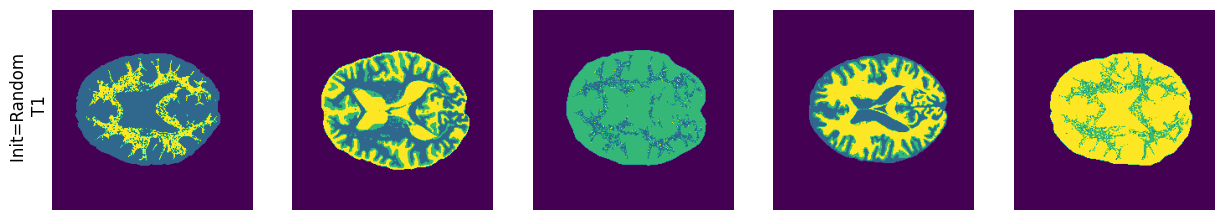

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True)

# Create a common x-axis label for the entire row of subplots
fig.text(0.11, 0.5, 'Ground Truth\n', va='center', ha='center', rotation='vertical', fontsize=12)

for i in range(0,5):
    data_folder_path    = os.path.join(os.getcwd(), f'../Lab 1/P2_data/{i+1}')
    labels_nifti, _     = NM.load_nifti(os.path.join(data_folder_path, 'LabelsForTesting.nii'))

    axes[i].imshow(labels_nifti[:,:,25])
    axes[i].set_title(f'Subject id {i+1}')
    axes[i].axis('off')  # Turn off axis labels
    
#################################################################
### SEGMENTATION RESULT - KMEANS INITIALIZATION - T1+T2-FLAIR ###
#################################################################

fig, axes = plt.subplots(1, 5, figsize=(15, 10), sharey=True)

# Create a common x-axis label for the entire row of subplots
fig.text(0.11, 0.5, 'Init=KMeans \nT1+T2-FLAIR', va='center', ha='center', rotation='vertical', fontsize=12)

for i in range(0,5):    
    subject_id = i+1
    segmentation_result = EM(subject_id, params_init_type='kmeans', modality='multi').fit(n_iterations=20)
    axes[i].imshow(segmentation_result[:,:,25])
    axes[i].axis('off')  # Turn off axis labels

#################################################################
####### SEGMENTATION RESULT - KMEANS INITIALIZATION - T1 ########
#################################################################

fig, axes = plt.subplots(1, 5, figsize=(15, 10), sharey=True)

# Create a common x-axis label for the entire row of subplots
fig.text(0.11, 0.5, 'Init=KMeans \nT1', va='center', ha='center', rotation='vertical', fontsize=12)

for i in range(0,5):   
    subject_id = i+1 
    segmentation_result = EM(subject_id, params_init_type='kmeans', modality='single').fit(n_iterations=20)
    axes[i].imshow(segmentation_result[:,:,25])
    axes[i].axis('off')  # Turn off axis labels

##################################################################
### SEGMENTATION RESULT - RANDOM INITIALIZATION - T1+T2-FLAIR ####
##################################################################

fig, axes = plt.subplots(1, 5, figsize=(15, 10), sharey=True)

# Create a common x-axis label for the entire row of subplots
fig.text(0.11, 0.5, 'Init=Random \nT1+T2-FLAIR', va='center', ha='center', rotation='vertical', fontsize=12)

for i in range(0,5):  
    subject_id = i+1  
    segmentation_result = EM(subject_id, params_init_type='random', modality='multi').fit(n_iterations=20)
    axes[i].imshow(segmentation_result[:,:,25])
    axes[i].axis('off')  # Turn off axis labels

##################################################################
######## SEGMENTATION RESULT - RANDOM INITIALIZATION - T1 ########
##################################################################

fig, axes = plt.subplots(1, 5, figsize=(15, 10), sharey=True)

# Create a common x-axis label for the entire row of subplots
fig.text(0.11, 0.5, 'Init=Random \nT1', va='center', ha='center', rotation='vertical', fontsize=12)

for i in range(0,5): 
    subject_id = i+1   
    segmentation_result = EM(subject_id, params_init_type='random', modality='single').fit(n_iterations=20)
    axes[i].imshow(segmentation_result[:,:,25])
    axes[i].axis('off')  # Turn off axis labels

##################################################################
plt.show()